## Packages
Install necessary packages: numpy, control, and multiprocessing.

In [1]:
%%capture
!pip install numpy control multiprocess matplotlib ipympl -U

In [2]:
# Import necessary packages
from typing import (
    Callable
)

import re

import numpy as np
import control as ct

from multiprocess import Pool

%matplotlib ipympl
import matplotlib.pyplot as plt

## Plot
Given a transfer function **H**, frequency range **\[start, end\]**, and propagation delay **delay**, we numerically approximate the transfer function given a square wave amplifier, which theoretically produces an infinite number of harmonics. If there is no propagation delay or it is already approximated in the transfer function, **delay** defaults to the floating point ε to approximate the limit form mentioned in Putzey's paper.

In [3]:
def plot(
    H: ct.TransferFunction, 
    start: float, 
    end: float, 
    delay=np.finfo(np.longdouble).eps
) -> None:
    """ Takes a SISO transfer function `H` and plots phase response and loop gain vs.
    frequency, oscillation frequency vs. duty cycle, DC transfer curve, and loop gain 
    vs. duty cycle. """

    # Range of frequencies
    omega = np.logspace(
        np.log10(start),
        np.log10(end),
        num=1_000,
        dtype=np.longdouble
    )
    
    # Range of duty cycles
    hs = np.linspace(0.1, 0.5, num=100, dtype=np.longdouble)

    with Pool() as p:
        # Range of harmonics to calculate
        ns = np.arange(1., 100., dtype=np.longdouble)
        
        # Avoid extra computation of Hz -> Rad/s constant
        rad = np.clongdouble(2j * np.pi)
            
        fs = np.fromiter(
            p.imap(
                lambda n: H(f := rad * n * omega) * np.exp(-delay * f), 
                ns, chunksize=ns.size // p._processes
            ),
            dtype=np.dtype((np.clongdouble,omega.size)),
            count=ns.size
        )

        def g(h: np.longdouble) -> np.ndarray:
            # Tmp variables to avoid double computation
            tmp = np.exp(rad * ns * h)
            tmp2 = (1 - (1 / tmp)) / (2 * ns)
            tmp3 = (1 - tmp) * tmp2

            # Calculate frequency response
            fr = np.einsum('a,ab->b', tmp3, fs)

            # Decompose frequency response
            mag = np.absolute(fr)
            ph = np.unwrap(np.angle(fr))
        
            # Identify falling zero-crossings of phase (inverting power stage adds pi phase shift)
            g = ph > -np.pi
            zc = g[:-1] & ~g[1:]
            ind = zc.size - np.argmax(np.flip(zc)) - 1

            # Binary search for exact zero-crossing frequency (within eps)
            start = omega[ind]
            end = omega[ind+1]
            p_err = np.nan

            max_iters = 100
            iters = 0
            while not np.isclose(p_err, -np.pi, rtol=1e-15, atol=1e-11):
                if iters > max_iters:
                    raise ValueError(f'Binary search did not converge in {max_iters} iterations, err={p_err}')
                # Guaranteed to run once and set mid because p_err == nan
                mid = (start + end) / 2

                tmp4 = H(f := rad * ns * mid) * np.exp(-delay * f)
                p_err = np.angle(tmp3 @ tmp4)

                if p_err > 0: end = mid
                else: start = mid

                iters += 1

            # Calculate dcin
            dcin = np.real((-tmp2 / 1j) @ tmp4) * (4 / np.pi)
            
            return mag, ph, mid, dcin
            

        res = np.fromiter(
            p.imap(g, hs, chunksize=hs.size // p._processes),
            dtype=np.dtype([
                ('mag', np.dtype((np.longdouble, omega.size))),
                ('ph', np.dtype((np.longdouble, omega.size))),
                ('osc_f', np.longdouble),
                ('dcin', np.longdouble)
            ]),
            count=hs.size
        )
        mags, phs, osc_fs, dcins = map(res.__getitem__, res.dtype.names)

        dcgains = np.gradient(hs * 2 - 1, -dcins)
    
    # Plotting
    fig, ((ax_ph, ax_dcgain), (ax_osc, ax_dcin)) = plt.subplots(2,2)

    # Set figure labels
    ax_osc.set_ylabel('Osc. Freq. (Hz)')
    ax_osc.set_xlabel('Duty Cycle')

    ax_ph.set_xlabel('Frequency (Hz)')
    ax_ph.set_ylabel('Phase (°)')
    ax_mag = ax_ph.twinx()
    ax_mag.set_ylabel('Magnitude (dB)')

    # Plot phase
    cs = ['b','g','c','y']
    for i, p in enumerate(phs[-1:0:-(hs.size // 5),:]):
        ax_ph.plot(omega, np.degrees(np.unwrap(p)), f'{cs[i % len(cs)]}--')

    ax_ph.plot([start, end], [-180, -180], 'k:')
    ax_ph.set_xscale('log')

    max_ph = max(np.ceil(np.degrees(np.max(phs))), 0) + 10
    ax_ph.set_yticks([0, -180, -360])
    ax_ph.set_ylim(-360-max_ph, max_ph)

    # Plot oscillation frequencies
    ax_osc.plot(
        np.concatenate((hs, 1-hs[-1::-1])),
        np.concatenate((osc_fs, osc_fs[-1::-1]))
    )

    # Plot dcin
    ax_dcin.plot(
        np.concatenate((-dcins, dcins[-1::-1])),
        np.concatenate((hs, 1-hs[-1::-1]))
    )

    # Plot dcgain
    ax_dcgain.plot(
        np.concatenate((hs, 1-hs[-1::-1])),
        np.concatenate((dcgains, dcgains[-1::-1]))
    )

    # Plot magnitudes
    mag_scaled = 20 * np.log10(dcgains[-1] * np.absolute(fs[0]))
    ax_mag.plot(omega, mag_scaled, 'r-')
    

    max_mag = round(max(
        *map(
            np.abs, 
            (np.min(mag_scaled), np.max(mag_scaled))
        ), 
        0
    )) + 3
    ax_mag.set_ylim(-max_mag, max_mag)

    fig.tight_layout()



## Transfer Functions

As per Bruno Putzey's 2011 paper titled ["Global Modulated Self-Oscillating Amplifier with Improved Linearity"](https://www.hypex.nl/media/3f/62/4a/1682342035/Globally%20modulated%20self-oscillating%20amplifier.pdf), we treat our Class-D amplifier as a square wave oscillator wrapped with a linear function. For simplicity's sake, we further split said linear function into three serial sections–the **propagation delay**, **low pass filter**, and **feedback network**. The **propagation delay** is calculated during numerical evaluation in order to avoid using a Padé approximation. Please define functions constructing transfer functions based on component values for the **low pass filter** and **feedback network** below.

In [13]:
def lpf(L: float, C: float, R_load: float) -> ct.TransferFunction:
    """ Function representing a common 2nd order output filter for Class-D amplifiers.
    Returns a transfer function per the corresponding values
    """
    return ct.tf([R_load], [R_load * L * C, L, R_load])

def fbn_example(R_in, C_in, R_lead, C_lead, R_fb, R_sep) -> ct.TransferFunction:
    s = ct.tf('s')

    b = R_lead + 1 / (C_lead * s)

    a = b + R_sep

    H_n = R_in * (a + R_fb) / (R_fb * a + R_in * a + R_fb *  R_in * a * C_in * s + R_fb * R_in)

    H = (R_sep + H_n * b) / (R_sep + b)

    return H

In [5]:
def load_sapwin(filename: str) -> Callable[[],ct.TransferFunction]:
    """ Parses a SapWin output file into a function that takes in component values and 
    outputs a transfer function. Allows offloading of the symbolic analysis of feedback
    networks for faster prototyping. Note that this function should only be called on trusted
    files, as it utilizes the eval function on parsed strings.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()[2:]

    all_vars = set()
    num_exprs = list()
    den_exprs = list()

    lst = num_exprs
    ord_count = 0
    
    for l in lines:
        if l == '\n':
            break
        if set(l[:-1]) == {'-'}:
            ord_count = 0
            lst = den_exprs
            continue

        expr = ""
        
        parens = re.search('\(.*\)', l)
        coef = parens.group()[1:-1]
        terms = re.findall('\S+', coef)
        varss = set(re.findall('\w+', coef))
        
        tail = l[parens.span()[-1]:]
        if lap := re.search('s(\^\d+)?', tail):
            tmp = re.search('\d+', lap.group())
            ordr = int(tmp.group()) if tmp else 1
        else: ordr = 0

        all_vars.update(varss)

        prev_var = False
        for t in terms:
            if t in varss:
                if prev_var:
                    expr += "*"
                prev_var = True
                expr += f"{{{t}}}"
                continue
            expr += t
            prev_var = False
        
        while ordr < ord_count:
            lst.append(0)
            ord_count += 1

        lst.append(expr)
        ord_count += 1
        
    def func(**kwargs):
        if(kwargs.keys() < all_vars):
            print(all_vars.difference(kwargs.keys()))
            raise ValueError(f"Missing {str(all_vars.difference(kwargs.keys()))}")

        def eval_coef(lst):
            return list(map(lambda e: eval(e.format(**kwargs)), reversed(lst)))

        num, den = map(eval_coef, (num_exprs, den_exprs))
        return ct.tf(num, den)

    return func

## Workspace

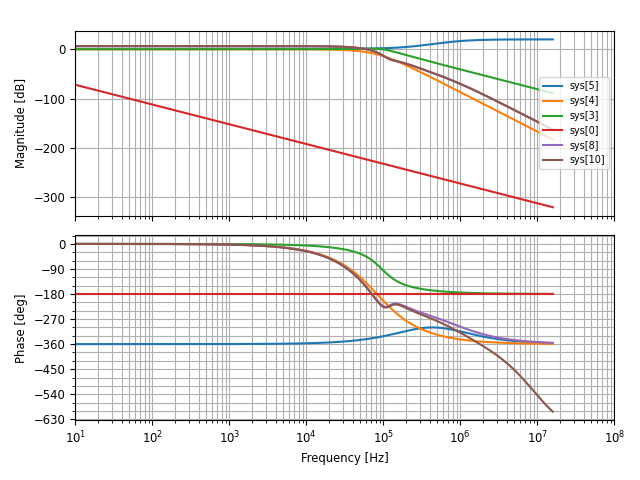

In [6]:
out = lpf(20e-6, 3.9e-6, 4)


iff = 50e3*2*np.pi

i_stages = list()
#for fsf, q in [(1.4192, 0.5219), (1.5912, 0.8055)]:
for fsf, q in [(1.6060, 0.5103), (1.6913, 0.6112), (1.9071, 1.0234)]:
    sf = iff * fsf
    i_stages.append(ct.tf([sf**2], [1, sf/q, sf**2]))

i_i = i_stages[0] * i_stages[1]
i_o = i_stages[2]

compf = 5*iff
compr = [3, 3]
comp = ct.zpk([-compf-1j, -compf+1j], [-r * compf for r in compr], 10)

fbn = (i_i + out) * (i_o + comp)
#fbn = i_i + out * (i_o + comp)

delay = 60e-9

plt.clf()

plot_kwargs = {'Hz': True, 'dB': True, 'omega_limits': (10, 100e6)}
for tf in (comp, i_i, i_o, out, fbn, fbn * ct.tf(*ct.pade(delay, n=2))):
    ct.bode_plot(tf, **plot_kwargs)

plt.show()

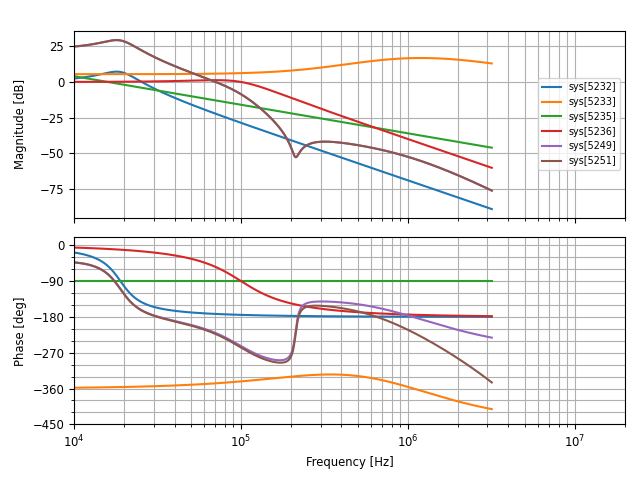

In [271]:
from functools import reduce

out = lpf(15e-6, 4.7e-6, 4)

intk = 1e5
ifilt = 100e3*2*np.pi

compfz = 3*ifilt
compfp = np.array([8, 12]) * ifilt
comp = ct.zpk([-compfz-1j, -compfz+1j], [-compfp[0]-1j, -compfp[0]+1j, -compfp[1]], 1e3*intk)


intt = intk / ct.tf('s')
#intt = ct.tf([1], [1])

ff = ct.tf([ifilt**2], [1, ifilt/1, ifilt**2])

fbks = [1e-2, 1]
ffk = 1e3
fbn = out * ((fbks[0] * ff + fbks[1] + comp) * intt + ff * fbks[0] * ffk + comp)


delay = 100e-9

plt.clf()
for tf in (out, comp, intt, ff, fbn, fbn * ct.tf(*ct.pade(delay, 2))):
    ct.bode_plot(tf, Hz=True, dB=True, omega_limits=(10e3, 20e6))

plt.show()

In [8]:
def disp(lst):
    return np.array(lst).flatten()

for tf in (comp, out, *i_tfs):
    print(*map(disp, (tf.num, tf.den)))
    print('')

[5.00000000e-01 1.50796447e+06 1.13697843e+12] [1.00000000e+00 9.04778684e+06 1.81916548e+13]

[4] [4.00e+00 2.00e-05 3.12e-10]

[1.80869715e+12] [1.00000000e+00 4.74082825e+06 1.80869715e+12]

[2.73974399e+12] [1.00000000e+00 2.96434845e+06 2.73974399e+12]

[2.18190299e+12] [1.00000000e+00 4.07066918e+06 2.18190299e+12]

[1.91965946e+12] [1.00000000e+00 4.54972736e+06 1.91965946e+12]



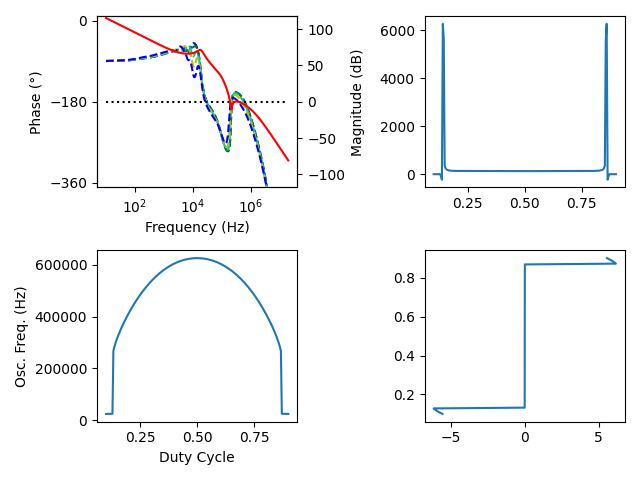

CPU times: user 372 ms, sys: 259 ms, total: 630 ms
Wall time: 1.31 s


In [272]:
%%time
    plot(fbn, 10, 20e6, delay=delay)
plt.show()

In [10]:
def disp(lst):
    return np.array(lst).flatten()

max_gain = 1

for tf in (comp, i_i, i_o, out):
    tf /= max_gain
    print(*map(disp, (tf.num, tf.den)))

[5.00000000e-01 1.50796447e+06 1.13697843e+12] [1.00000000e+00 9.04778684e+06 1.81916548e+13]
[7.18673896e+22] [1.00000000e+00 1.85804711e+06 1.39640205e+12 5.00431073e+17
 7.18673896e+22]
[3.58960513e+11] [1.00000000e+00 5.85433980e+05 3.58960513e+11]
[4] [4.00e+00 2.00e-05 3.12e-10]
